In [1]:
!git clone https://github.com/ultralytics/yolov5.git # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16051, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 16051 (delta 46), reused 44 (delta 25), pack-reused 15967
Receiving objects: 100% (16051/16051), 14.69 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (11012/11012), done.
/content/yolov5


In [2]:
pwd

'/content/yolov5'

In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [5]:

%cd /content


/content


In [6]:
!unzip /content/mask_detector.zip

Archive:  /content/mask_detector.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/WIN_20231104_21_56_24_Pro_jpg.rf.bd235856150e4f113a4958c38756254f.jpg  
 extracting: test/images/WIN_20231104_21_56_30_Pro_jpg.rf.37519d4c74dd4e6bf26b1d26f8d5b58e.jpg  
 extracting: test/images/WIN_20231104_21_58_10_Pro_jpg.rf.f5971ef9841c6ede5160da194f26db8d.jpg  
 extracting: test/images/WIN_20231104_21_58_34_Pro_jpg.rf.890e20d202ca7e470f6e17fc17be5968.jpg  
 extracting: test/images/WIN_20231104_21_59_33_Pro_jpg.rf.2d26a4b1cfa8735d5ba1f4be511437df.jpg  
 extracting: test/images/WIN_20231104_21_59_36_Pro_jpg.rf.1a9b1024ccc733718ea8394428c91582.jpg  
 extracting: test/images/WIN_20231104_21_59_38_Pro_jpg.rf.b064bb114fa7e57543bdcee55273e178.jpg  
 extracting: test/images/WIN_20231104_22_00_10_Pro_jpg.rf.cfdd636dd1eb387b76a6287ec187f7ba.jpg  
 extracting: test/images/WIN

In [7]:
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['Mask', 'NoMask']

roboflow:
  workspace: data-science-b47gw
  project: mask_detector-eaes9
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/data-science-b47gw/mask_detector-eaes9/dataset/1

In [8]:

#this is the model configuration we will use
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [9]:

# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [10]:
num_classes

'2'

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [14]:
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 5 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
2023-11-04 17:25:17.973681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 17:25:17.973742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 17:25:17.973794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=5, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optim

In [15]:
'''
step by step explainaton:

%%time: This is a special Jupyter Notebook command used to measure the execution time of the entire cell.

%cd /content/yolov5/: This command changes the current working directory to /content/yolov5/. It seems like the script is expecting to be run from this specific directory.

!python train.py: This command invokes the Python interpreter to execute the script train.py.

The following are the command-line arguments passed to the train.py script:

--img 640: This argument specifies the input image size for the training data.

--batch 5: This argument sets the batch size for the training process.

--epochs 300: This argument specifies the number of epochs for training.

--data '../data.yaml': This argument provides the path to the data configuration file (data.yaml).

--cfg ./models/custom_yolov5s.yaml: This argument points to the model configuration file (custom_yolov5s.yaml) for the YOLOv5s architecture.

--weights 'yolov5s.pt': This argument specifies the path to the pre-trained weights file (yolov5s.pt).

--name yolov5s_results: This argument sets the name of the results directory for saving the training output.

--cache: This argument enables caching during the training process, which can speed up subsequent training runs.

The overall purpose of this script is to train an object detection model using YOLOv5. The script seems to be configured to use specific settings for the model architecture, data, and training parameters. The yolov5s architecture is a smaller version of YOLOv5, suitable for environments with limited computational resources. The script will save the training results in the yolov5s_results directory.


'''

"\nstep by step explainaton:\n\n%%time: This is a special Jupyter Notebook command used to measure the execution time of the entire cell.\n\n%cd /content/yolov5/: This command changes the current working directory to /content/yolov5/. It seems like the script is expecting to be run from this specific directory.\n\n!python train.py: This command invokes the Python interpreter to execute the script train.py.\n\nThe following are the command-line arguments passed to the train.py script:\n\n--img 640: This argument specifies the input image size for the training data.\n\n--batch 5: This argument sets the batch size for the training process.\n\n--epochs 300: This argument specifies the number of epochs for training.\n\n--data '../data.yaml': This argument provides the path to the data configuration file (data.yaml).\n\n--cfg ./models/custom_yolov5s.yaml: This argument points to the model configuration file (custom_yolov5s.yaml) for the YOLOv5s architecture.\n\n--weights 'yolov5s.pt': This a

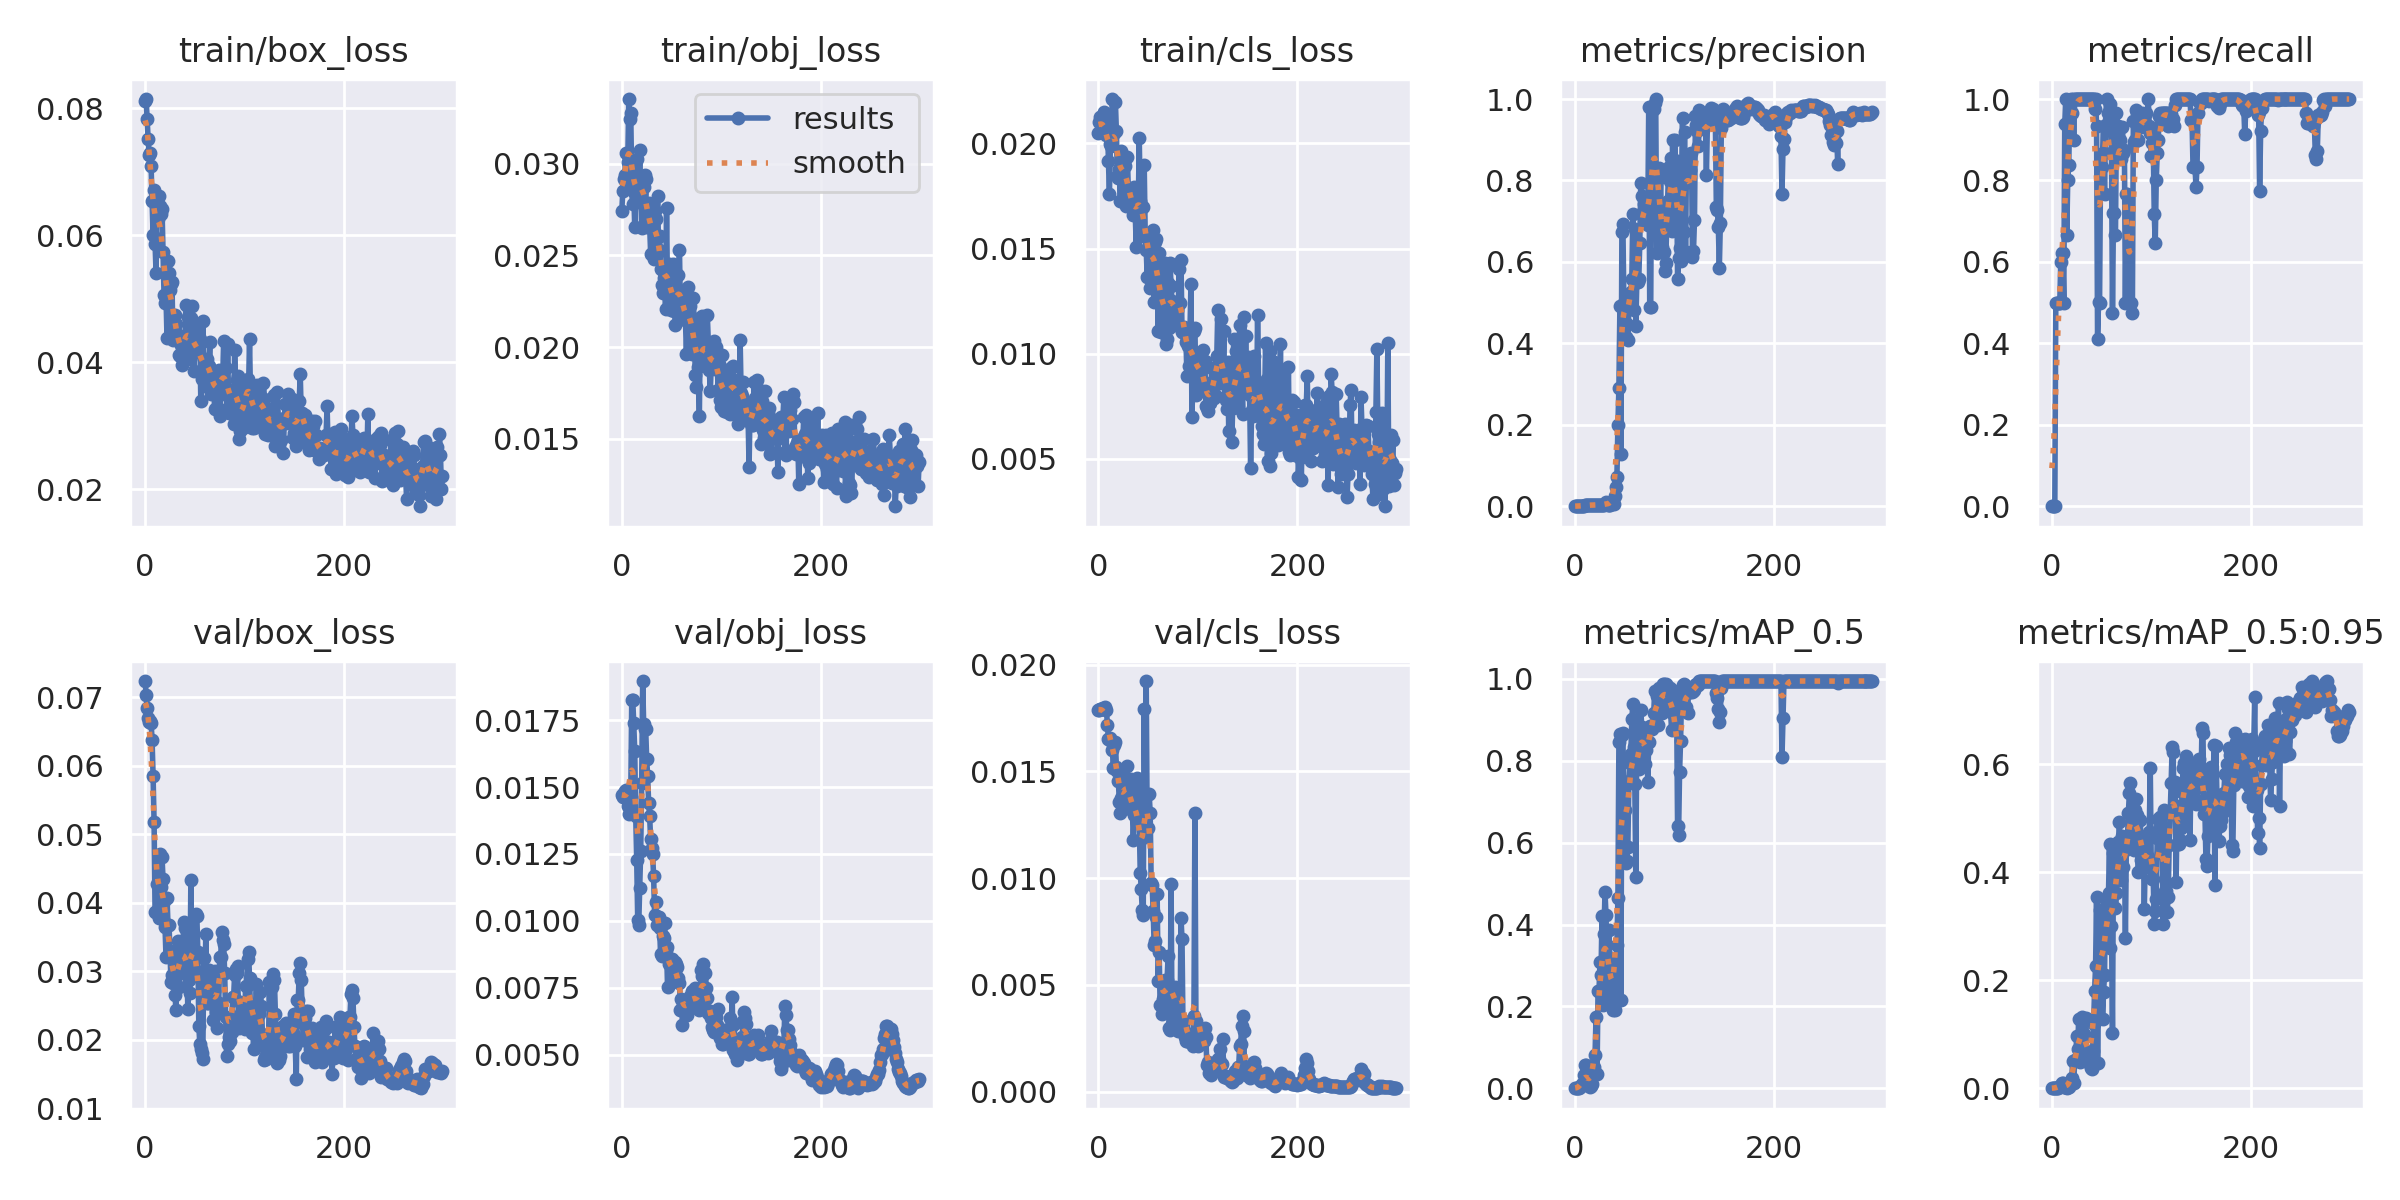

In [16]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


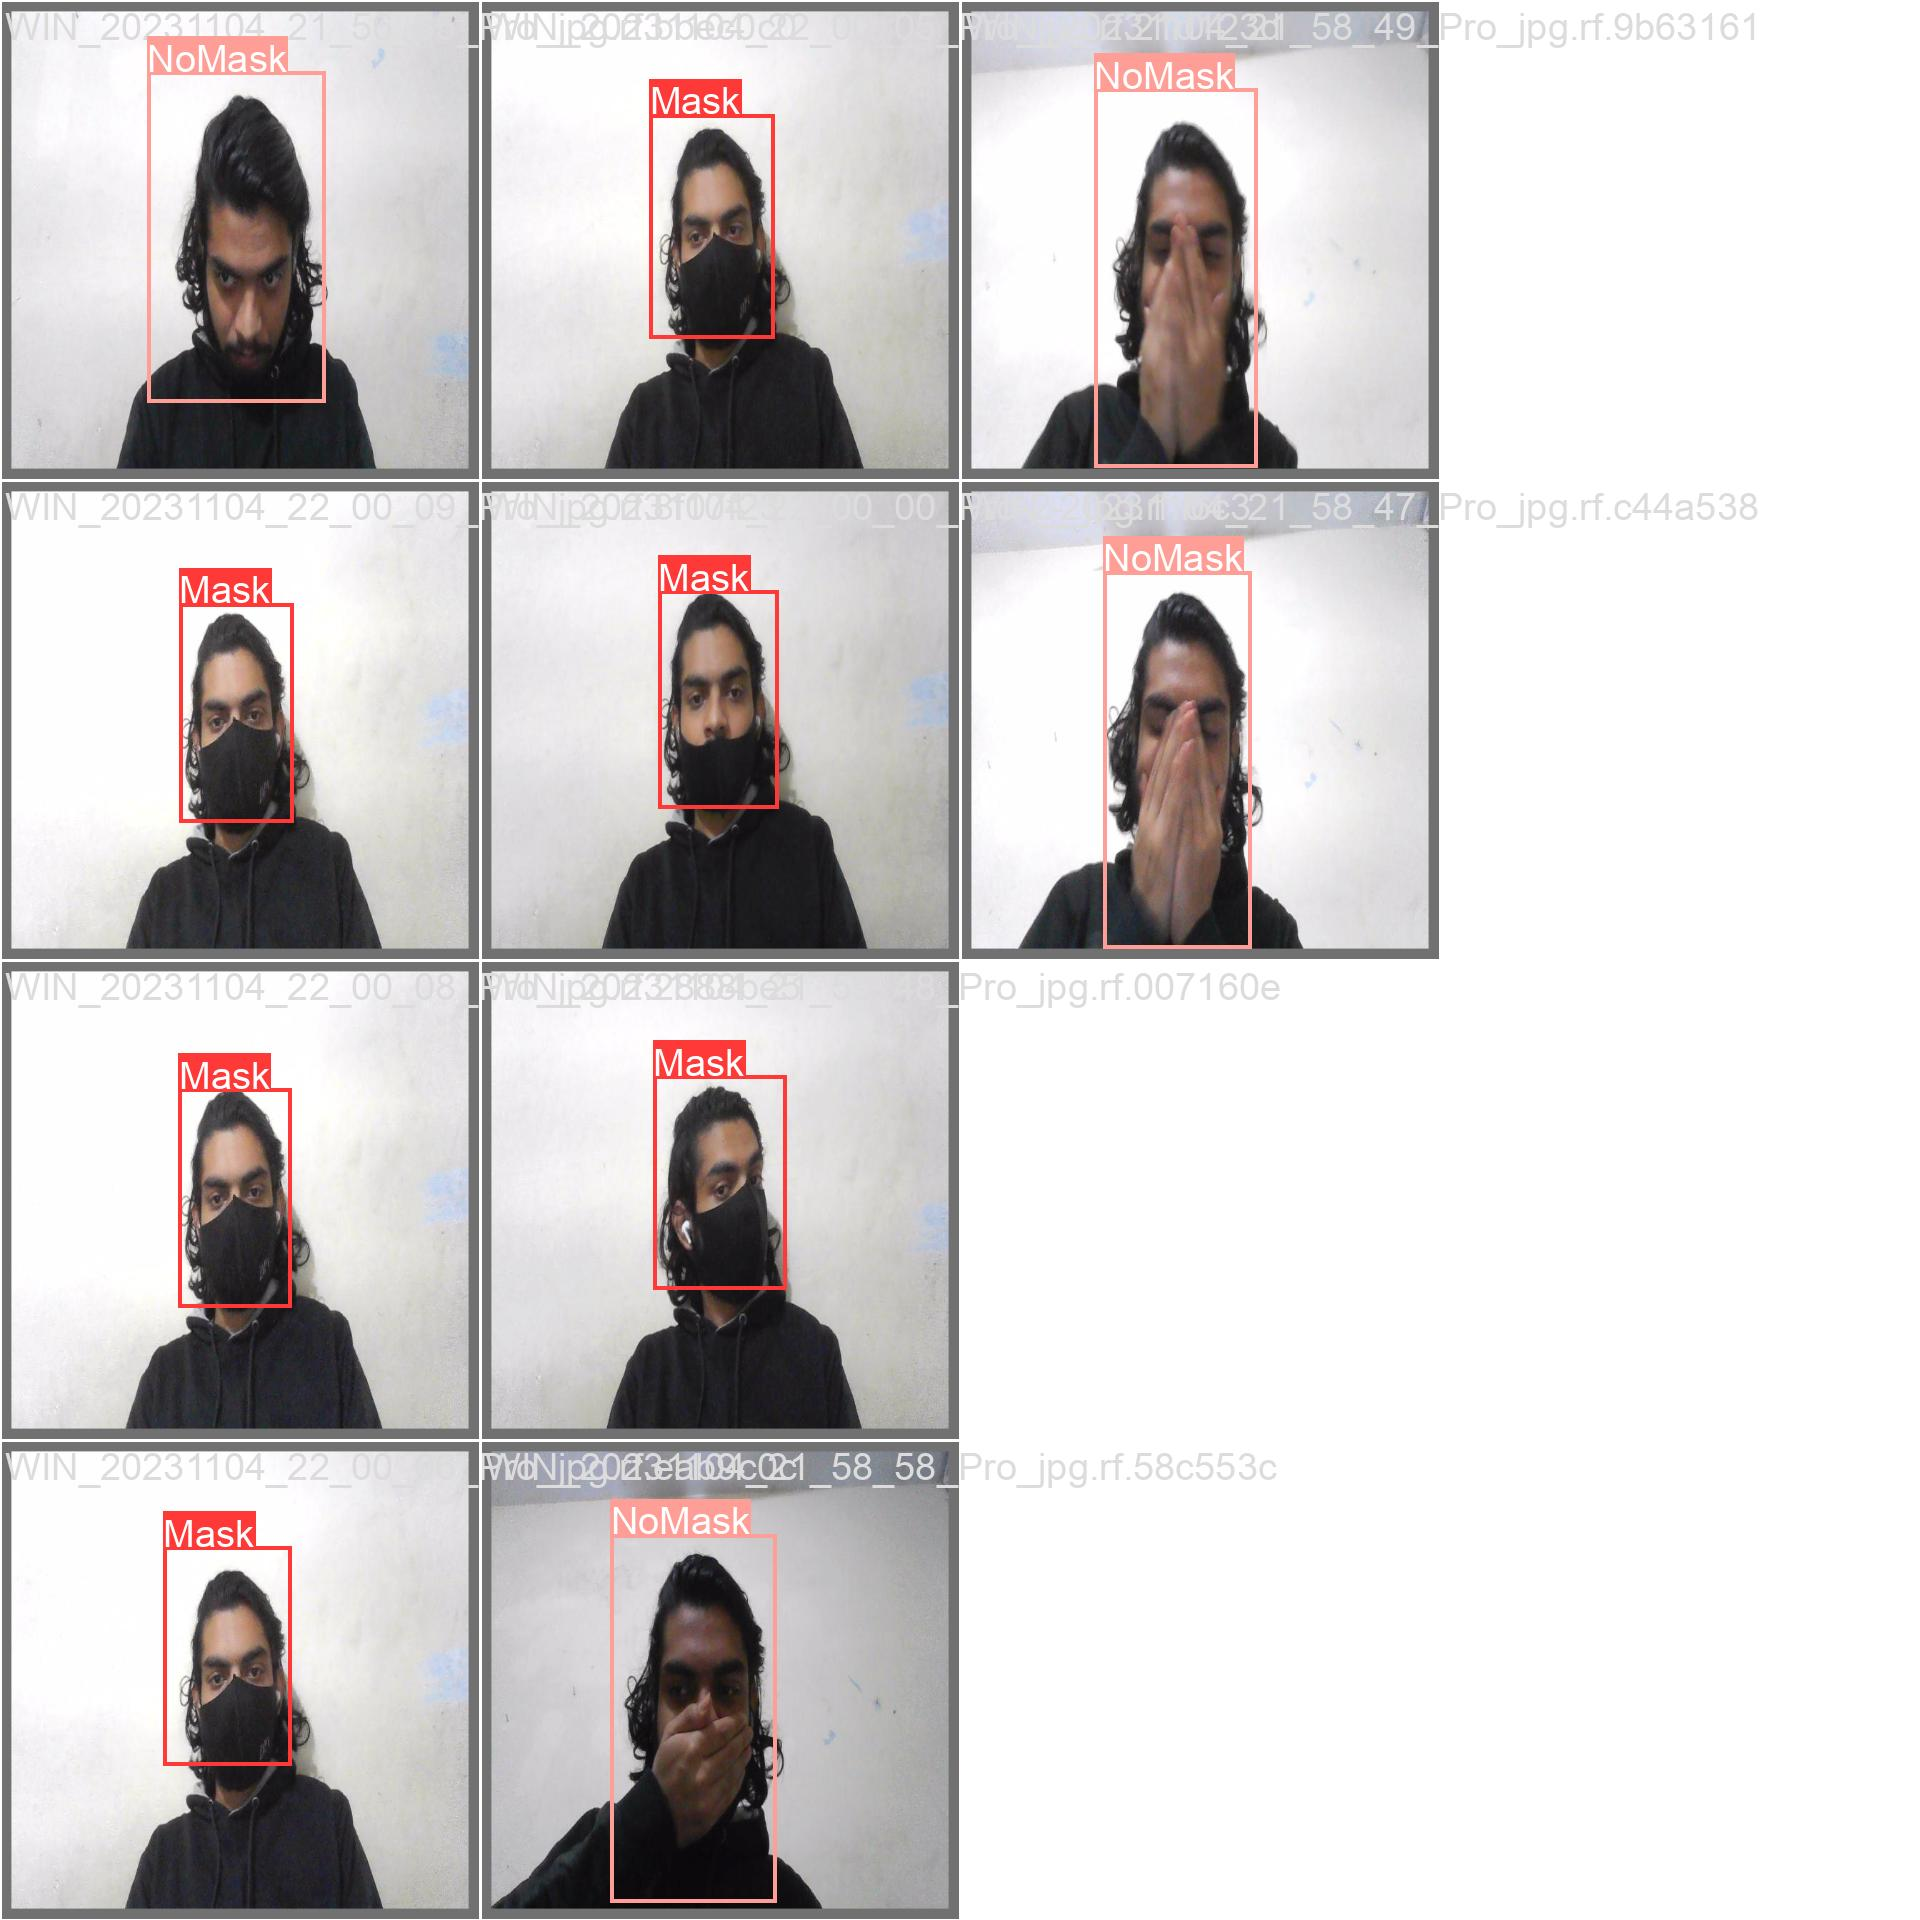

In [17]:

# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


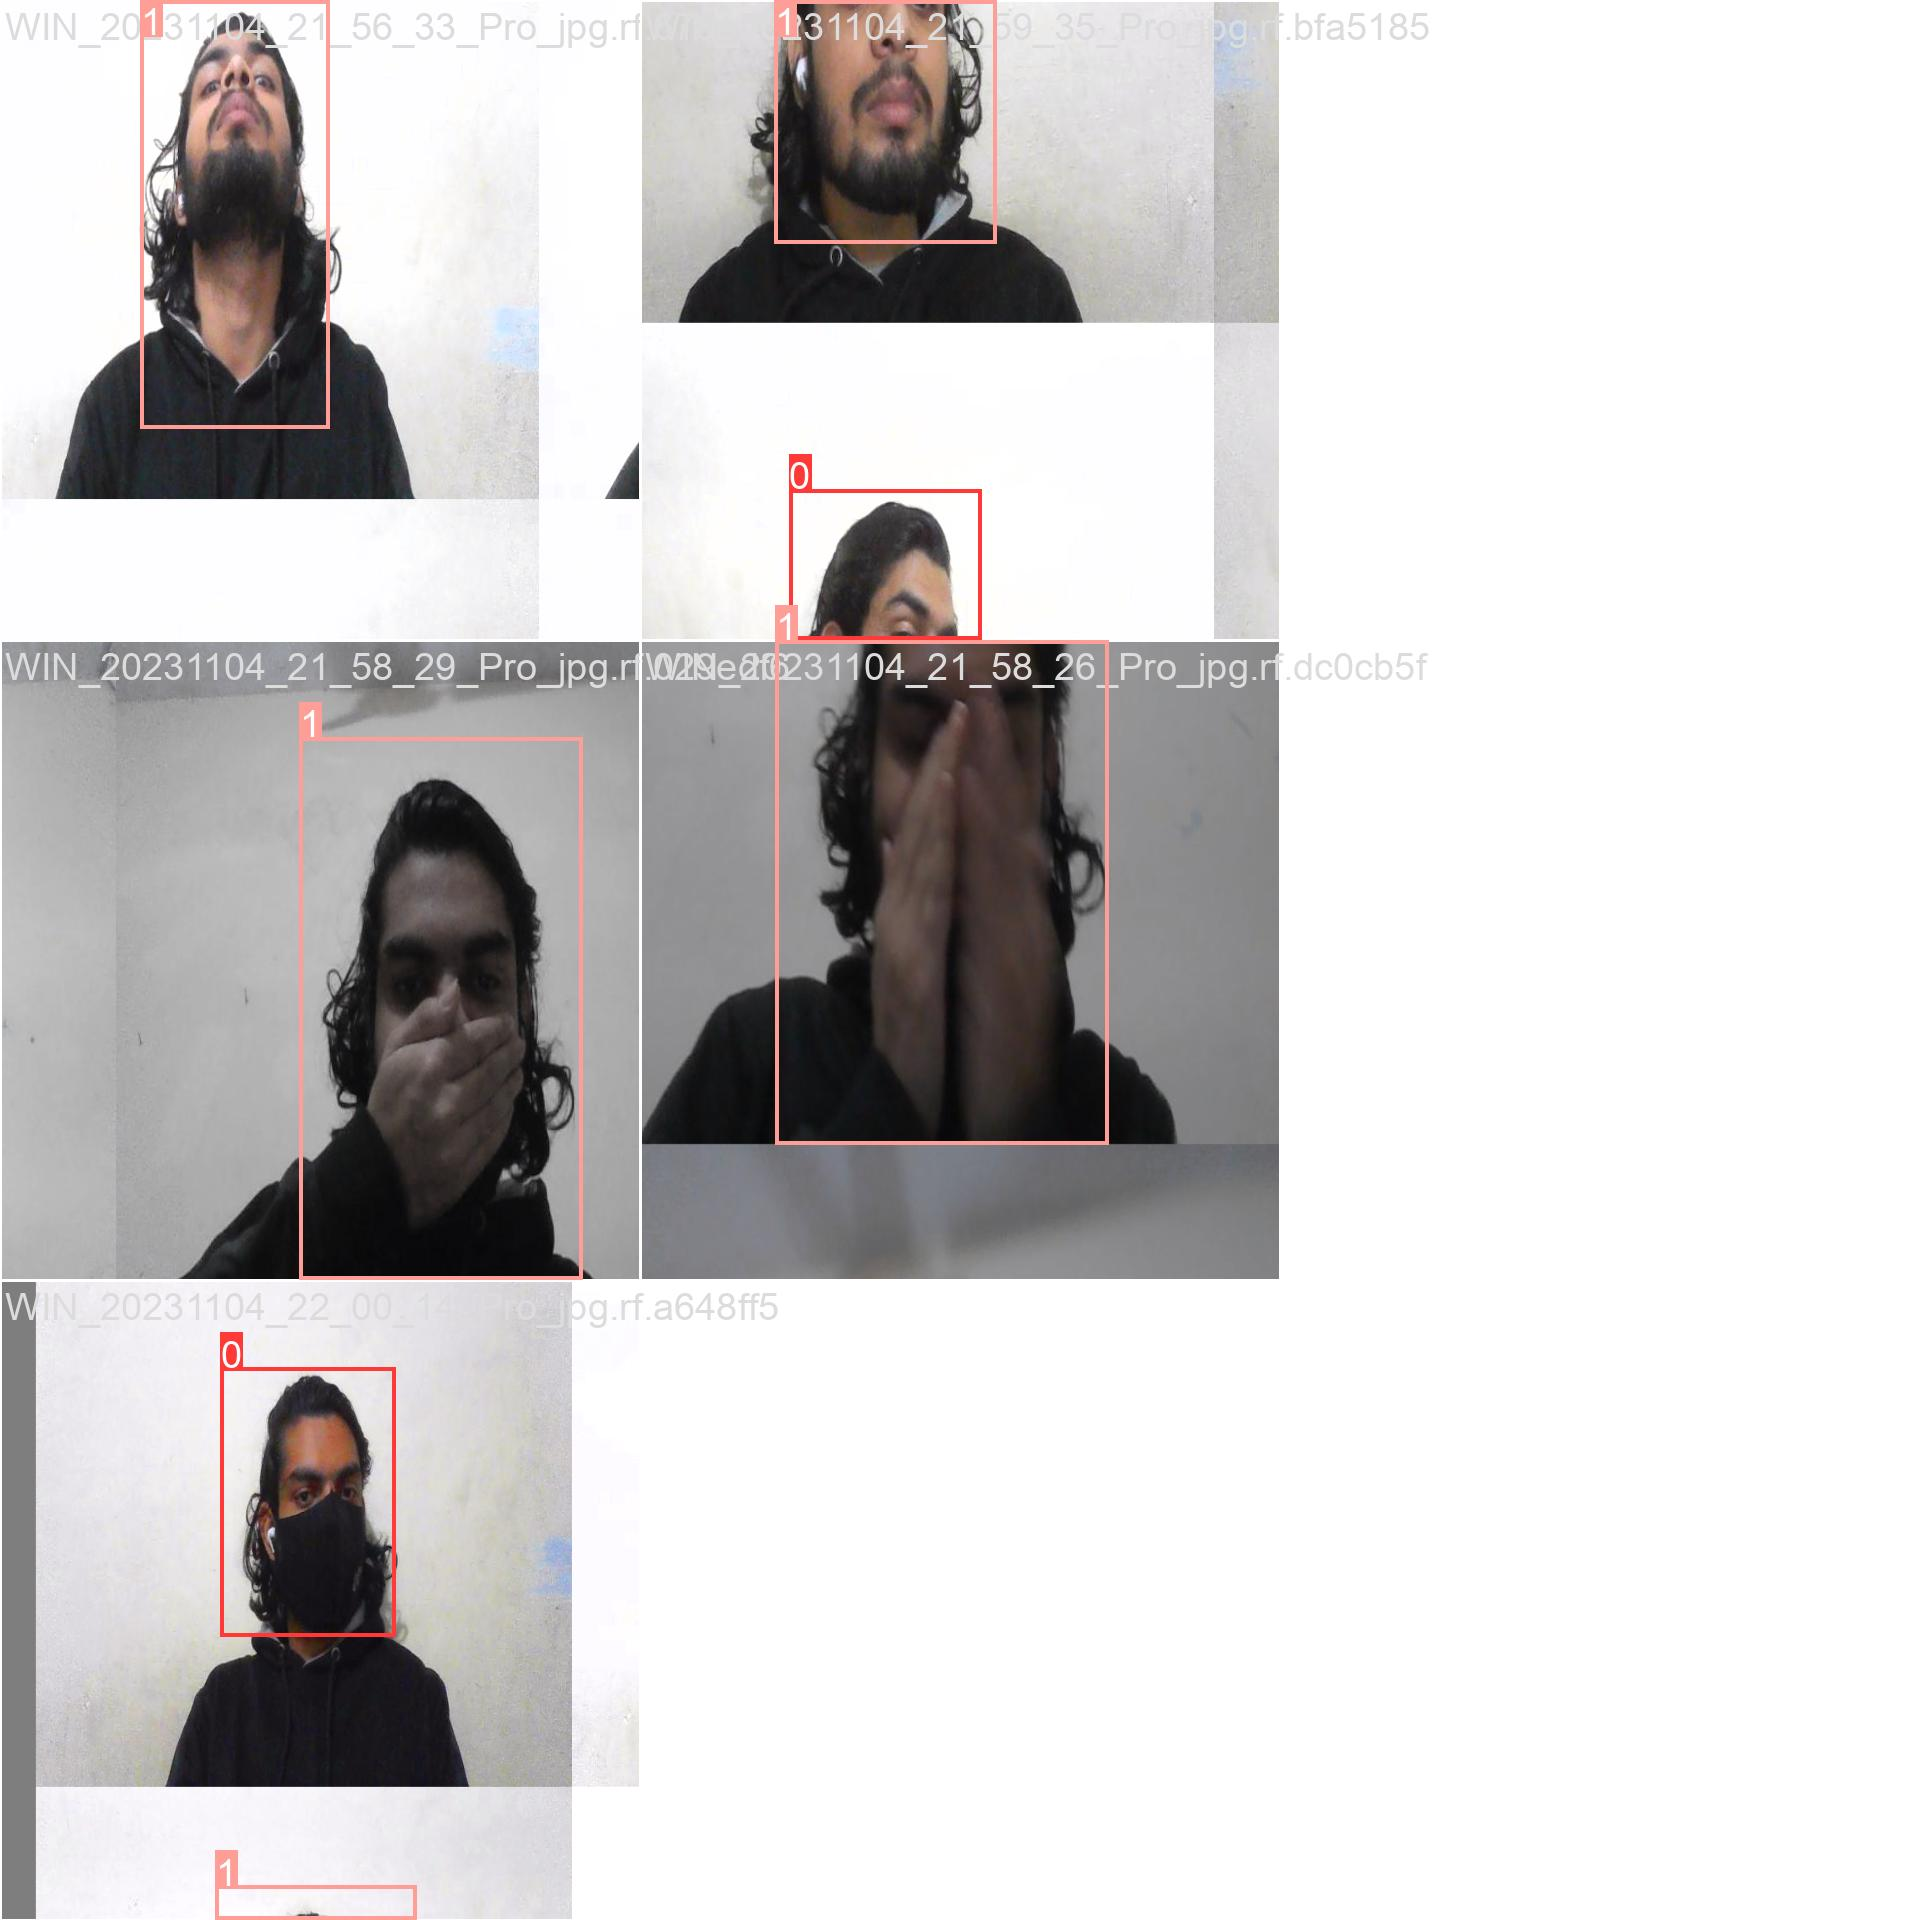

In [18]:

# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [20]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.5 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-235-g6ca8f33 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/9 /content/test/images/WIN_20231104_21_56_24_Pro_jpg.rf.bd235856150e4f113a4958c38756254f.jpg: 640x640 1 NoMask, 12.5ms
image 2/9 /content/test/images/WIN_20231104_21_56_30_Pro_jpg.rf.37519d4c74dd4e6bf26b1d26f8d5b58e.jpg: 640x640 1 NoMask, 12.6ms
image 3/9 /content/test/images/WIN_20231104_21_58_10_Pro_j